In [1]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv1D, Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from itertools import groupby
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [2]:
kaggle_environment = True # True if running on Kaggle, don't forget to add the dataset!

if kaggle_environment:
    data_path = '/kaggle/input/'
else:
    data_path = 'kaggle/input/'

In [3]:
train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
revealed_targets = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
test = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
sample_submission = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv')

In [4]:
columns_to_difference = ['bid_price', 'ask_price']
columns_to_impute = ['far_price', 'near_price']
columns_to_interpolate = ['bid_price', 'ask_price']
lagged_columns = ['far_price', 'near_price']
n_lags = 2
start_time = pd.to_datetime('2023-01-01 08:00:00')
end_time = pd.to_datetime('2023-01-01 0:00:00')


In [5]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class CustomIterativeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, max_iter=10, random_state=0):
        self.columns = columns
        self.max_iter = max_iter
        self.random_state = random_state
        self.imputer = None

    def fit(self, X, y=None):
        # Initialize the IterativeImputer
        self.imputer = IterativeImputer(max_iter=self.max_iter, random_state=self.random_state)
        self.imputer.fit(X[self.columns])
        return self

    def transform(self, X):
        # Check is fit had been called
        if self.imputer is None:
            raise RuntimeError("You must call fit before calling transform")
        
        # Fit the imputer and transform the data
        X[self.columns] = self.imputer.transform(X[self.columns])
        return X

# Define the columns you want to impute
columns_to_impute = ['far_price', 'near_price']

# Create the pipeline with the custom imputer
pipeline = Pipeline([
    ('iterative_imputer', CustomIterativeImputer(columns=['far_price', 'near_price'])),
    # Add other steps here if necessary
])

# Use the pipeline on a DataFrame `df`
df_processed = pipeline.fit_transform(train)


In [6]:
df_processed

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,1.001772,0.999660,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,1.001772,0.999660,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,1.001772,0.999660,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,1.001772,0.999660,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,1.001772,0.999660,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [7]:
import pandas as pd

def preprocess_and_interpolate(df, columns_to_interpolate, freq='T', order=3):
    """
    Preprocess and interpolate specified columns of a DataFrame minute-wise grouped by stock_id.

    Parameters:
    df (pandas.DataFrame): DataFrame to process.
    columns_to_interpolate (list of str): Columns to apply interpolation.
    freq (str): Frequency for resampling. Default is 'T' for minute-wise.
    order (int): Order of spline interpolation. Default is 3.

    Returns:
    pandas.DataFrame: Processed and interpolated DataFrame.
    """
    # Create a time range for the 8-hour day
    start_time = pd.Timestamp('4:00:00')  # Market open at 8 AM
    end_time = pd.Timestamp('16:00:00')  # Market close at 4 PM
    # Assuming 540 seconds is the time span for the closing auction.
    trading_seconds = (end_time - start_time).seconds - 540
    seconds_in_day = (end_time - start_time).seconds

    # Map 'seconds_in_bucket' to the actual time within the 8-hour window
    df['actual_time'] = pd.to_timedelta(df['seconds_in_bucket'], unit='s') + start_time

    # Ensure the actual time does not go beyond the market closing time
    df['actual_time'] = df['actual_time'].apply(lambda x: x if x <= end_time else end_time)

    # Set the timestamp as the index
    df.set_index('actual_time', inplace=True)

    # Initialize an empty DataFrame to store the results
    resampled_dfs = []

    # Group by 'stock_id' and process each group
    for stock_id, group in df.groupby('stock_id'):
        # Handle duplicates
        if group.index.duplicated().any():
            group = group[~group.index.duplicated(keep='first')]

        # Resample the data
        group_resampled = group.resample(freq).asfreq()

        # Interpolate for each column
        for column in columns_to_interpolate:
            group_resampled[column] = group_resampled[column].interpolate(method='spline', order=order)
        
        # Add the stock_id back to the DataFrame
        group_resampled['stock_id'] = stock_id

        # Append the processed group to the list
        resampled_dfs.append(group_resampled)

    # Concatenate all the processed groups
    df_resampled = pd.concat(resampled_dfs)
    df_resampled.reset_index(inplace=True)
    df_new = df_resampled.drop(['actual_time'], axis=1)

    return df_new

In [8]:
#trial = df_processed.drop(['time_id'], axis=1)
imputed_df = preprocess_and_interpolate(df_processed, ['bid_price', 'ask_price'])
y = imputed_df['target'].values
no_time = imputed_df.drop(['target'], axis=1)
X = no_time.to_numpy(dtype='float32')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
imputed_df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,1.001772,0.999660,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,0,0,60,1218204.43,1,1.000562,15342674.90,1.001772,0.999660,1.000455,14005.50,1.000562,10085.04,1.000517,-0.200272,6,0_60_0
2,0,0,120,1216057.90,1,1.000133,15460827.57,1.001772,0.999660,0.999812,43482.46,1.000026,68224.23,0.999895,2.290011,12,0_120_0
3,0,0,180,1445736.98,1,0.999705,15642349.64,1.001772,0.999660,0.999598,18658.00,0.999705,9330.00,0.999669,-3.029704,18,0_180_0
4,0,0,240,1783022.73,1,0.999705,15687146.86,1.001772,0.999660,0.999491,37778.40,0.999705,37320.00,0.999598,2.130270,24,0_240_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,199,88,300,16037831.49,1,1.000818,16836941.87,1.229196,1.100820,1.000818,197658.00,1.001218,4305.16,1.001210,37.330390,4870,88_300_199
1996,199,88,360,11933481.61,1,1.005618,20929716.97,1.240886,1.106020,1.005618,32883.12,1.006018,17605.00,1.005879,1.660585,4876,88_360_199
1997,199,88,420,10558331.77,1,1.006018,22304866.80,1.241785,1.106420,1.005618,70366.86,1.006018,31839.90,1.005894,-7.939935,4882,88_420_199
1998,199,88,480,2195659.82,1,1.005218,30667538.75,1.006818,1.006418,1.004818,49787.84,1.005218,11308.50,1.005144,-4.569888,4888,88_480_199


In [10]:
def generate_features(cumulative_test_df, current_test, pipeline):
    transformed_df = pipeline.transform(cumulative_test_df)
    # Only return rows corresponding to the current test dataframe
    transformed_df = preprocess_and_interpolate(transformed_df, ['bid_price', 'ask_price'])
    test_df = transformed_df.iloc[-len(current_test):]
    #print(test_df)
    test_df.to_numpy(dtype='float32')
    output = scaler.fit_transform(test_df)
    return output

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv1D, Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization


class TemporalBlock(Layer):
    def __init__(self, n_filters, kernel_size, dilation_rate):
        super(TemporalBlock, self).__init__()
        self.conv1 = Conv1D(
            filters=n_filters,
            kernel_size=kernel_size,
            padding='causal',
            dilation_rate=dilation_rate
        )
        self.batch_norm1 = BatchNormalization()
        self.conv2 = Conv1D(
            filters=n_filters,
            kernel_size=kernel_size,
            padding='causal',
            dilation_rate=dilation_rate
        )
        self.batch_norm2 = BatchNormalization()
        self.dropout = Dropout(0.5)
    
    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.batch_norm1(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        x = self.conv2(x)
        x = self.batch_norm2(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        return x + inputs  # Residual connection

class TCN(Layer):
    def __init__(self, n_filters, kernel_size, dilation_rates):
        super(TCN, self).__init__()
        self.blocks = [TemporalBlock(n_filters, kernel_size, dr) for dr in dilation_rates]

    def call(self, inputs, training=False):
        x = inputs
        for block in self.blocks:
            x = block(x, training=training)
        return x

# Define the TCN model
n_filters = 64
kernel_size = 5
dilation_rates = [1, 2, 4, 8]  # exadilation rates

input_layer = Input(shape=(None, 1))  # univariate time series; change 1 to n_features if multivariate
tcn_layer = TCN(n_filters, kernel_size, dilation_rates)(input_layer)
output_layer = Dense(1)(tcn_layer)  # regression task

m = Model(inputs=input_layer, outputs=output_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipvalue=1.0)
m.compile(optimizer=optimizer, loss='mae')
m.summary()
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
m.fit(X_scaled, y, epochs=17, callbacks=[early_stopping])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 tcn (TCN)                   (None, None, 64)          146240    
                                                                 
 dense (Dense)               (None, None, 1)           65        
                                                                 
Total params: 146,305
Trainable params: 145,281
Non-trainable params: 1,024
_________________________________________________________________
Epoch 1/17
63/63 [==============================] - 9s 40ms/step - loss: 6.7373
Epoch 2/17
63/63 [==============================] - 2s 36ms/step - loss: 6.6286
Epoch 3/17
63/63 [==============================] - 2s 36ms/step - loss: 6.6054
Epoch 4/17
63/63 [==============================] - 2s 36ms/step - loss: 6.

In [12]:
ok = m.predict(X_scaled)
y_pred = ok[:, 0, 0] 


63/63 [==============================] - 1s 9ms/step


In [13]:
print(len(y))

y_test = y

2000


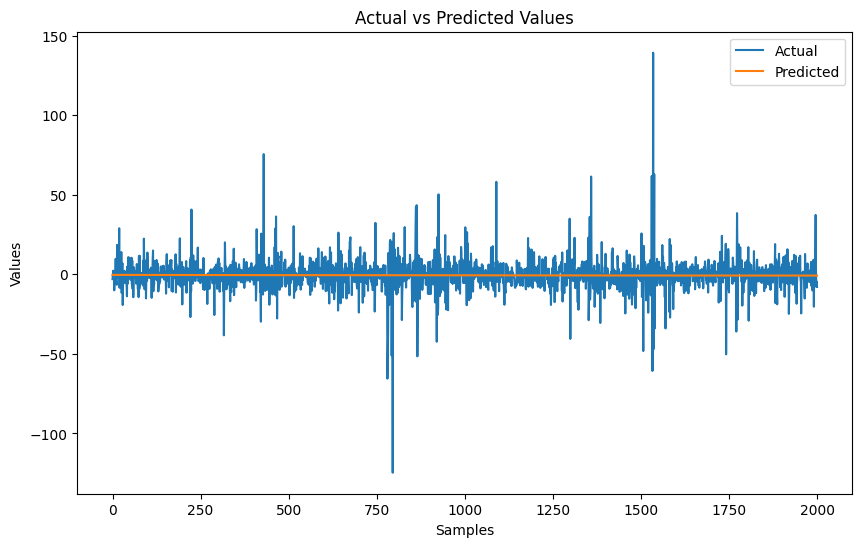

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()


In [15]:
print(y_test.shape)
print(y_pred.shape)


(2000,)
(2000,)


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")


MAE: 6.538532251716811
MSE: 113.3199041906764
R2 Score: -0.00031303672672100546


In [17]:
if kaggle_environment:
    import optiver2023
    env = optiver2023.make_env()
    iter_test = env.iter_test()

In [18]:
# test_in= generate_features(cumulative_test_df, test_in,pipeline)
# ok = m.predict(test_in)
# print(ok[:, 0, 0]  )
# sample_prediction["target"] =  ok[:, 0, 0] 

# print(sample_prediction)
# #env.predict(sample_prediction)

In [19]:
if kaggle_environment:
    # To count how many time the "for loop" runs.
    counter = 0

    # init 3 empty lists
    test_ls, revealed_targets_ls, sample_prediction_ls = [], [], []
    cumulative_test_df = pd.DataFrame()

    for (test_in, revealed_targets, sample_prediction) in iter_test:
        # Append the dataframe that API return into the list.
        test_ls.append(test_in.copy())
        revealed_targets_ls.append(revealed_targets.copy())
        sample_prediction_ls.append(sample_prediction.copy())
        cumulative_test_df = pd.concat([cumulative_test_df, test_in], axis=0, ignore_index=True)

        # Generate features
        test_transformed = generate_features(cumulative_test_df, test_in, pipeline)
        predictions =  m.predict(test_transformed)


        # Writes our predictions 
        sample_prediction["target"] = predictions[:, 0, 0] 
        
        # This line submit our predictions.
        env.predict(sample_prediction)
        counter += 1

    print('\n', '=' * 50, sep="")
    print(f"counter: {counter}")

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
7/7 [==============================] - 0s 6ms/step

counter: 165
